# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 4 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Load training data

In [3]:
data_path = '../data/cleaned'
models_path = '../models'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 4398 entries, ID to ENSG00000272168
dtypes: float64(4394), object(4)
memory usage: 21.5+ MB


### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

In [4]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

Encode labels

In [5]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

3    372
2    114
1     95
0     59
Name: Stage, dtype: int64

Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [6]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [7]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [8]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-06 20:22:55,907] A new study created in memory with name: no-name-37e1e953-f73c-4e9b-8216-7a614ab5225f
[I 2023-06-06 20:23:25,004] Trial 0 finished with value: 0.3676947189113388 and parameters: {'n_estimators': 92, 'max_depth': 8, 'learning_rate': 0.3165909436214853, 'subsample': 0.7398097764224679, 'colsample_bytree': 0.958805616826473, 'gamma': 0.26828400267085717}. Best is trial 0 with value: 0.3676947189113388.
[I 2023-06-06 20:23:42,965] Trial 1 finished with value: 0.33177446649066955 and parameters: {'n_estimators': 87, 'max_depth': 5, 'learning_rate': 0.06388533629925945, 'subsample': 0.606078771341184, 'colsample_bytree': 0.5432587057500269, 'gamma': 4.253253483926645}. Best is trial 0 with value: 0.3676947189113388.
[I 2023-06-06 20:23:51,464] Trial 2 finished with value: 0.34443694320665896 and parameters: {'n_estimators': 37, 'max_depth': 2, 'learning_rate': 0.1782037529590942, 'subsample': 0.502399198989262, 'colsample_bytree': 0.9650846837615104, 'gamma': 3.15

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [9]:
study.best_params

{'n_estimators': 91,
 'max_depth': 8,
 'learning_rate': 0.48166396878122,
 'subsample': 0.8173978513594714,
 'colsample_bytree': 0.7927279052085104,
 'gamma': 1.1816238565620614}

In [10]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

Define function for plotting confusion matrix

In [8]:
def plot_confusion_matrix(cm, labels, title=None, scores_subtitle=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    if title is not None:
        plt.title(title, y=1.12, fontsize=20)
    if scores_subtitle is not None:
        plt.suptitle(scores_subtitle, y=0.08, fontsize=14)

    fig.show()

In [12]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.41      0.22      0.29        59
          II       0.22      0.08      0.12        95
         III       0.20      0.10      0.13       114
          IV       0.66      0.92      0.77       372

    accuracy                           0.58       640
   macro avg       0.37      0.33      0.33       640
weighted avg       0.49      0.58      0.51       640



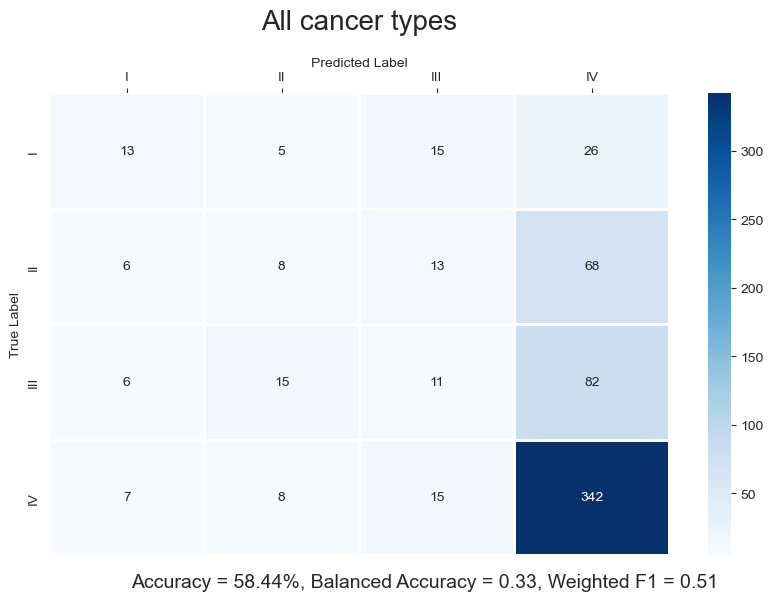

In [13]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

Check model performance for each cancer type separately

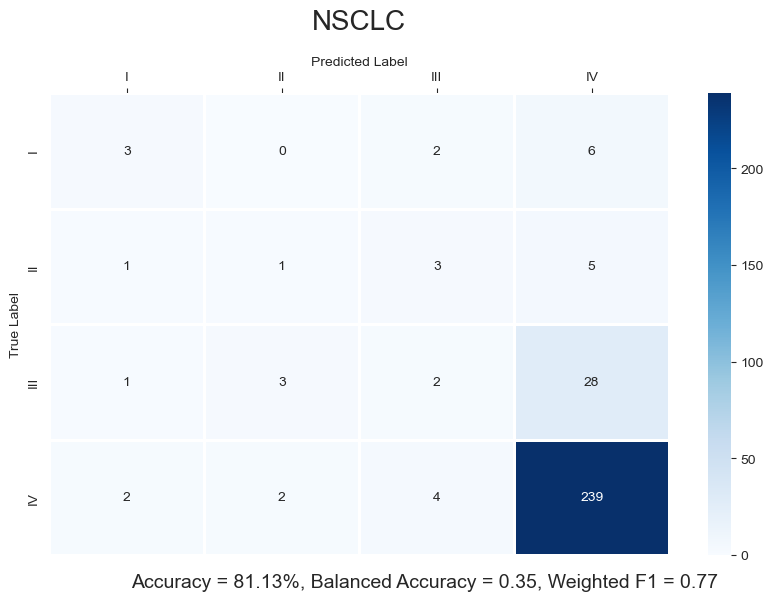

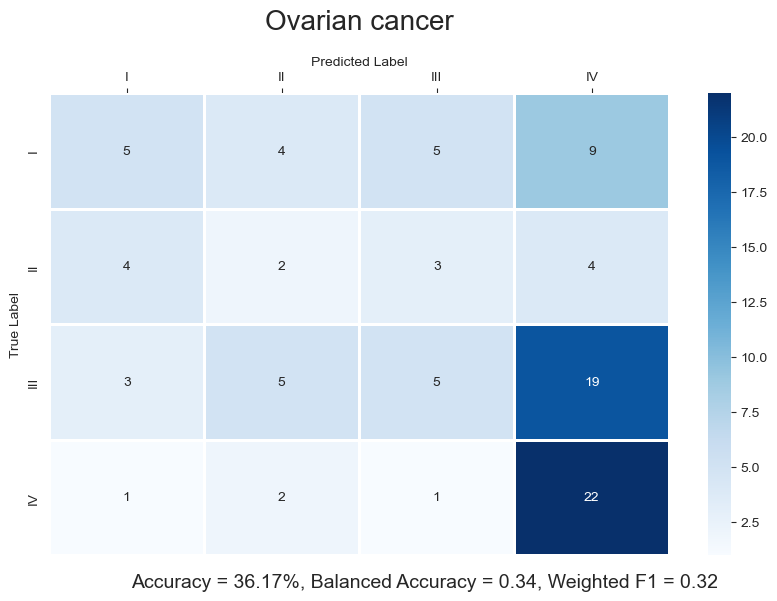

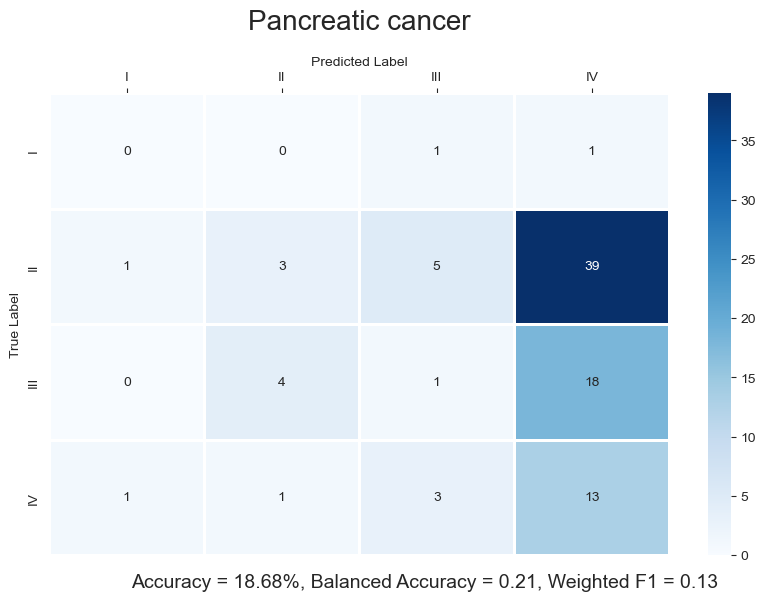

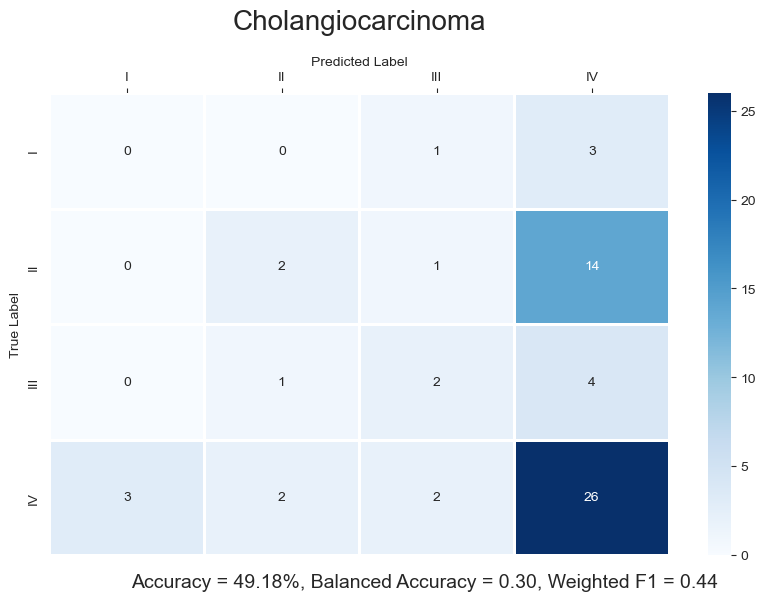

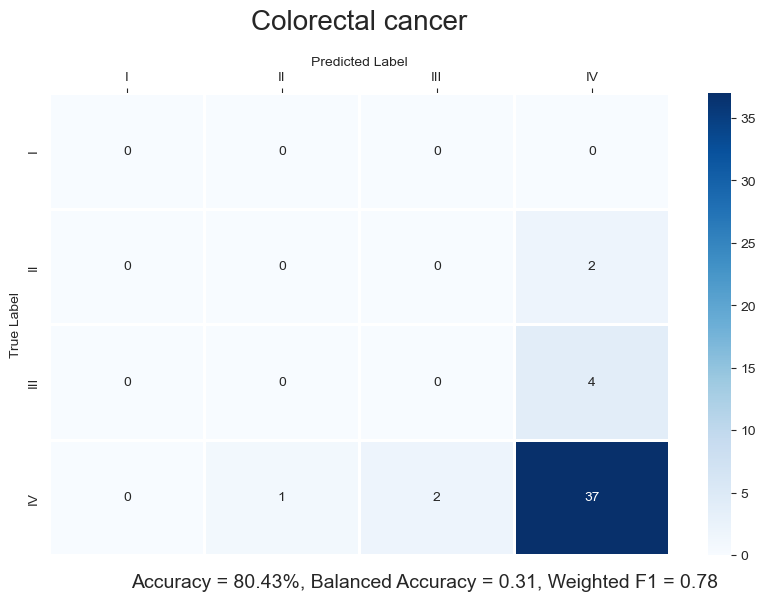

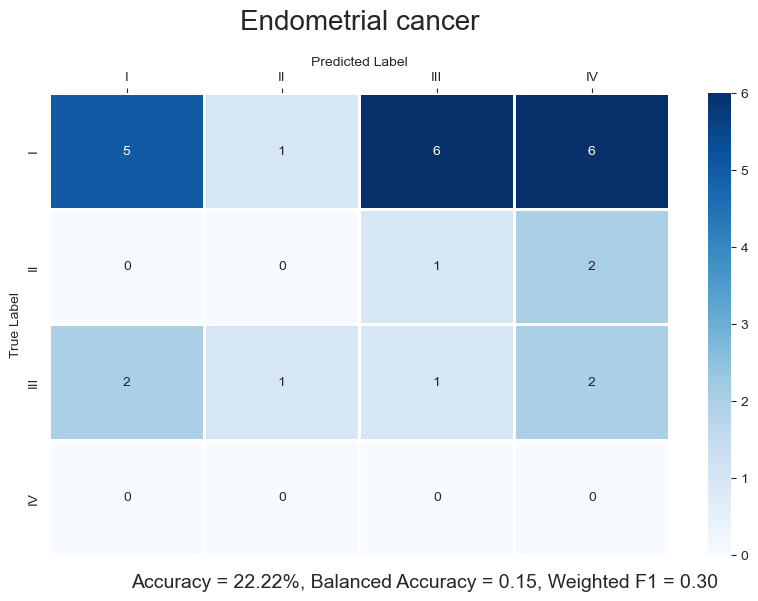

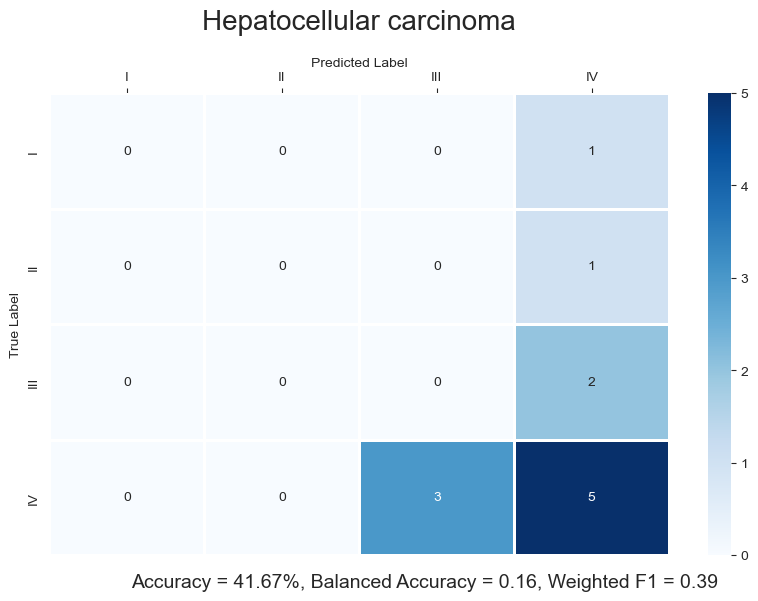

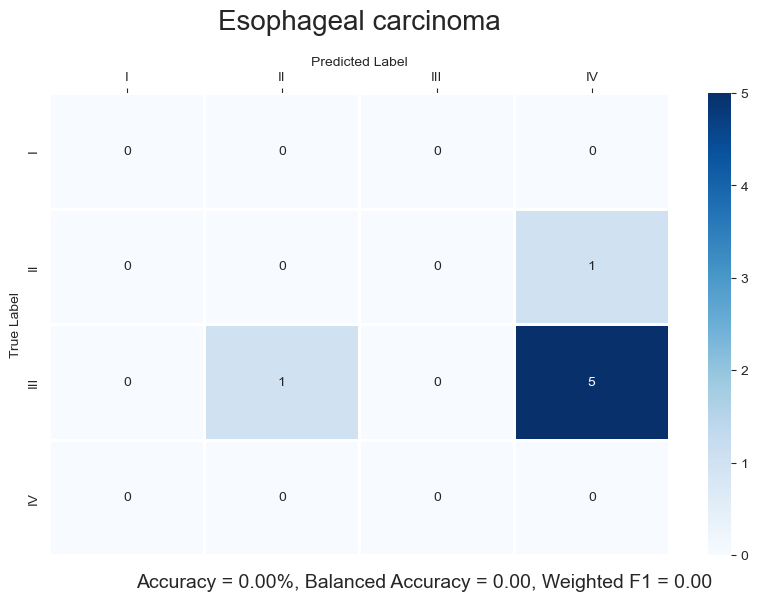

In [14]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'], average='weighted')
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1, 2, 3])

    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    plot_confusion_matrix(cm, labels, title=group_name, scores_subtitle=scores_subtitle)

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

In [15]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

In [16]:
stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

Encode labels

In [17]:
labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    372
0    268
Name: Stage, dtype: int64

Run hyperparameters optimization

In [18]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-06 20:56:57,706] A new study created in memory with name: no-name-e1611b5b-b5ef-4f63-a9d9-82d451889625
[I 2023-06-06 20:57:05,459] Trial 0 finished with value: 0.681797199219524 and parameters: {'n_estimators': 48, 'max_depth': 7, 'learning_rate': 0.4928856330375139, 'subsample': 0.9817142962685705, 'colsample_bytree': 0.849926409336026, 'gamma': 2.447622471452036}. Best is trial 0 with value: 0.681797199219524.
[I 2023-06-06 20:57:11,903] Trial 1 finished with value: 0.7081381562514912 and parameters: {'n_estimators': 22, 'max_depth': 6, 'learning_rate': 0.3898504746038102, 'subsample': 0.6786224693844789, 'colsample_bytree': 0.8506560979138359, 'gamma': 2.0226578599011784}. Best is trial 1 with value: 0.7081381562514912.
[I 2023-06-06 20:57:18,490] Trial 2 finished with value: 0.6873600919019973 and parameters: {'n_estimators': 32, 'max_depth': 4, 'learning_rate': 0.3184851963382584, 'subsample': 0.5589785943699966, 'colsample_bytree': 0.7543954110597033, 'gamma': 0.898059

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [19]:
study.best_params

{'n_estimators': 107,
 'max_depth': 6,
 'learning_rate': 0.08199151461424278,
 'subsample': 0.8066958503437625,
 'colsample_bytree': 0.5762514531408115,
 'gamma': 0.01497759960772288}

In [20]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [21]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.71      0.60      0.65       268
          IV       0.74      0.83      0.78       372

    accuracy                           0.73       640
   macro avg       0.73      0.71      0.72       640
weighted avg       0.73      0.73      0.73       640



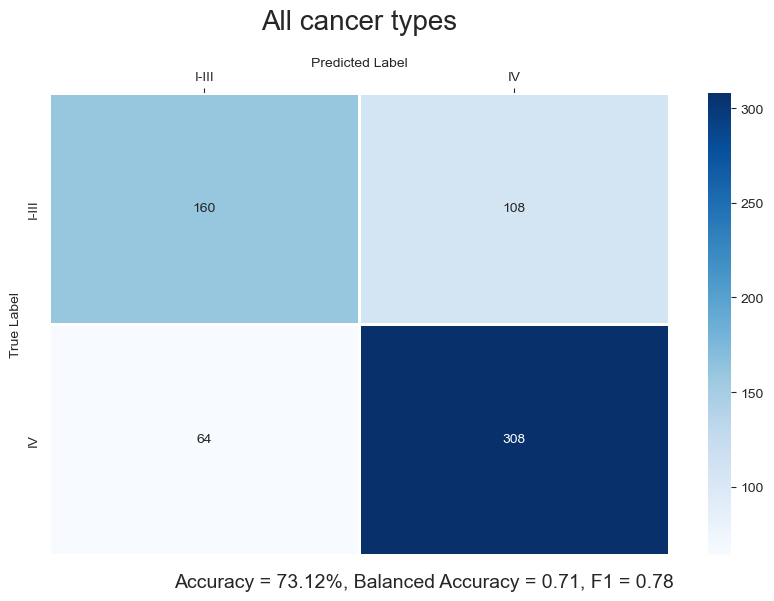

In [22]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

Check model performance for each cancer type separately

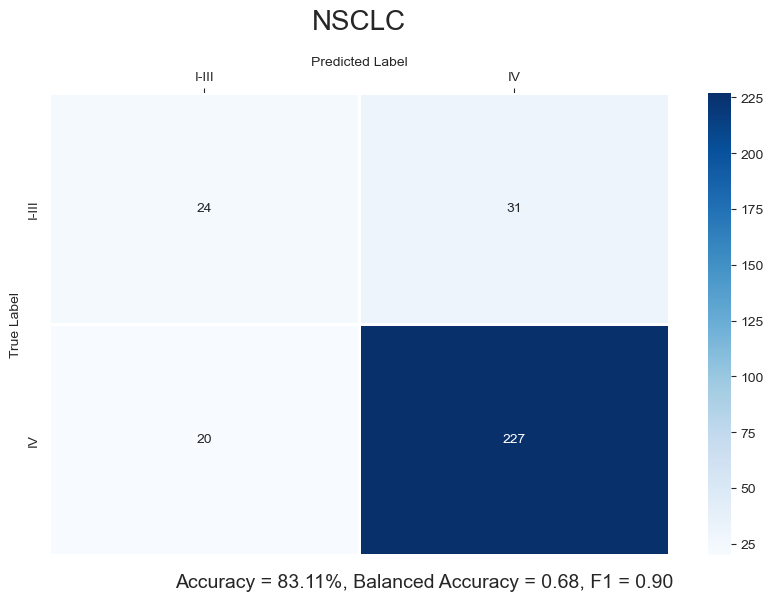

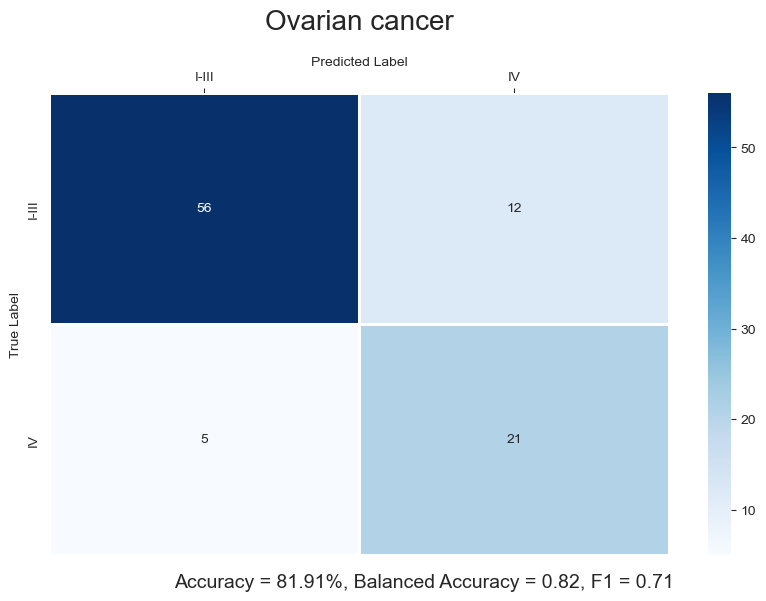

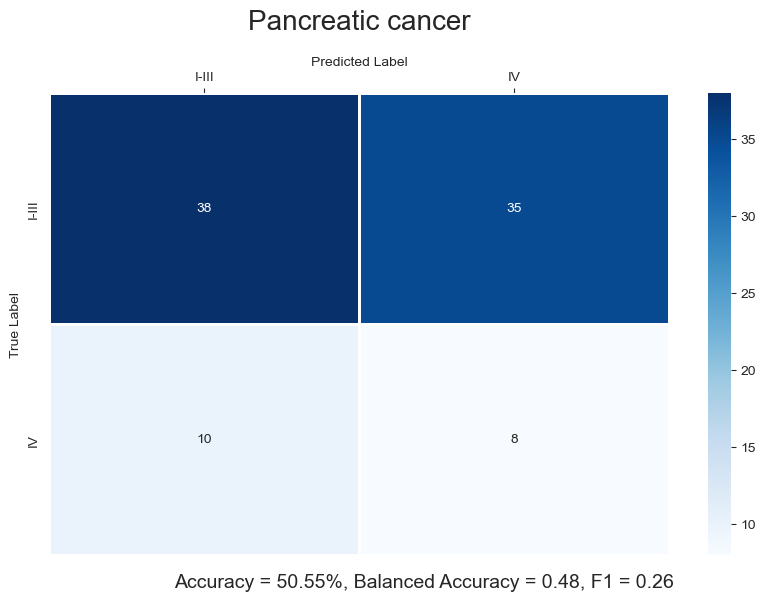

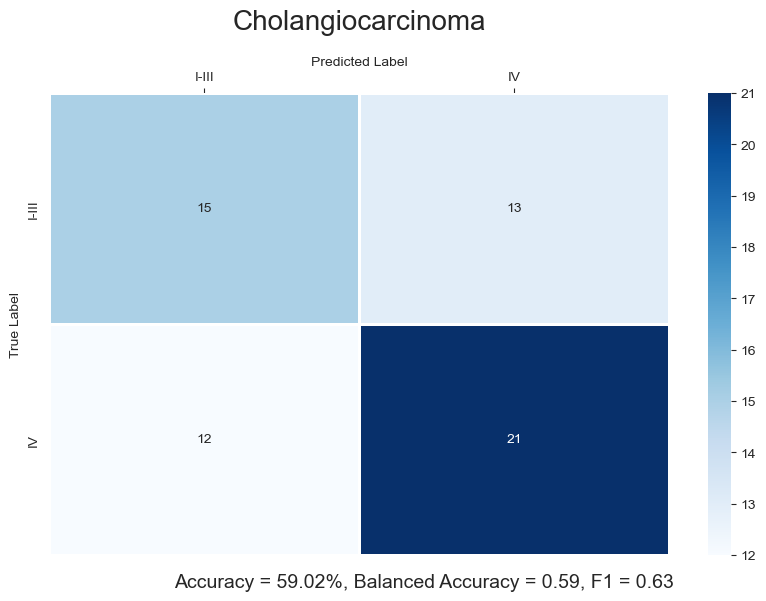

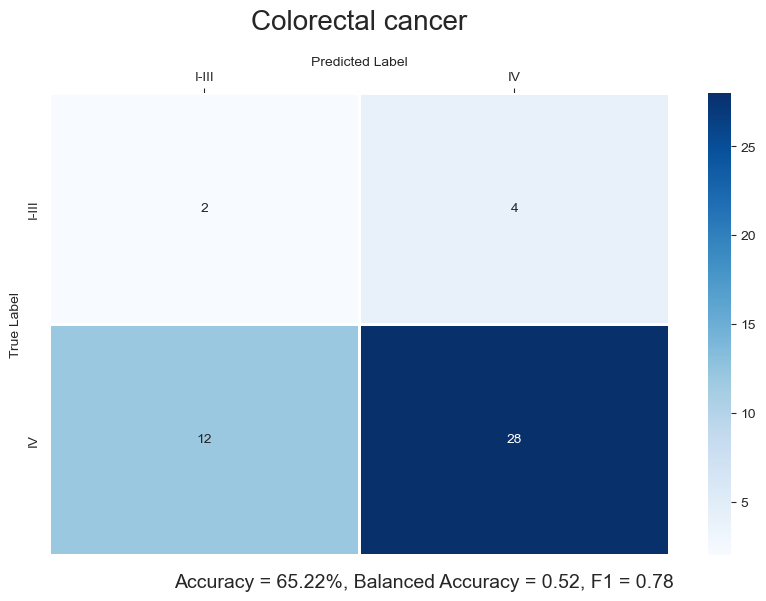

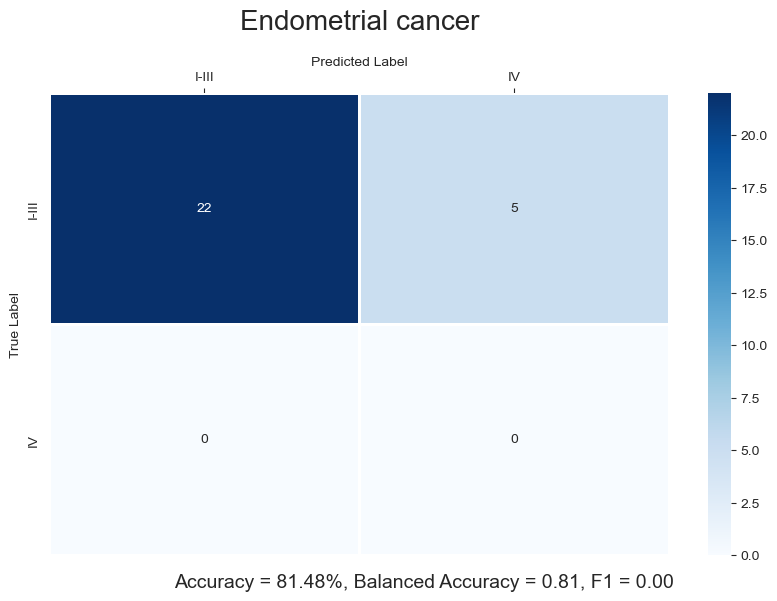

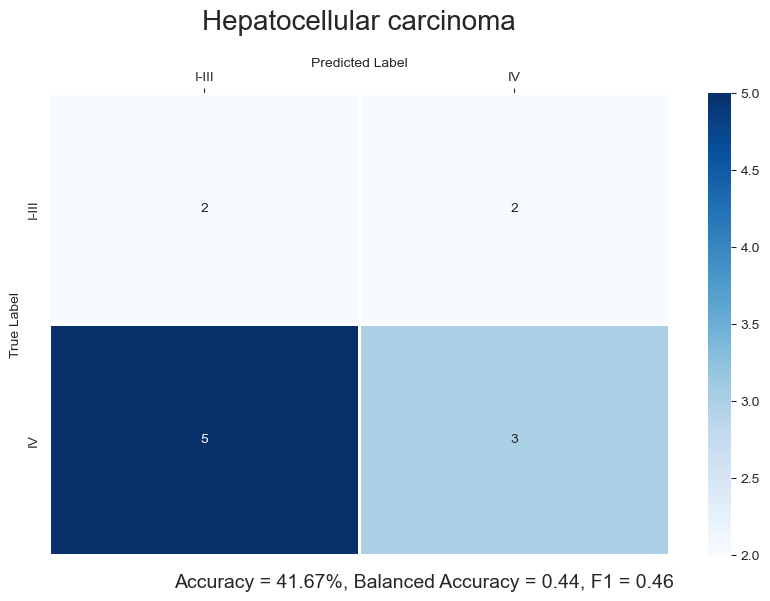

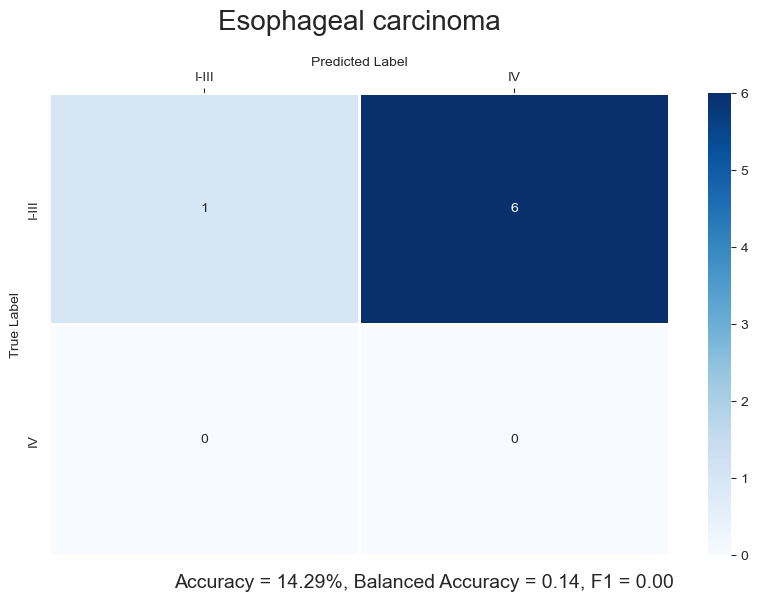

In [23]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

    plot_confusion_matrix(cm, labels, title=group_name, scores_subtitle=scores_subtitle)

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [27]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'num_class': 4,
}

scoring_func = balanced_accuracy_score

Get only the most numerous cancer types (with more than 90 cases)

In [25]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'Ovarian cancer', 'Pancreatic cancer']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [26]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    247
2     34
0     11
1     10
Name: Stage, dtype: int64

In [28]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-07 15:23:09,669] A new study created in memory with name: no-name-3dbaf25b-2993-48d0-9be2-fb5c525e8a3d
[I 2023-06-07 15:23:21,270] Trial 0 finished with value: 0.2489754098360656 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.46519501501181615, 'subsample': 0.8884934403741936, 'colsample_bytree': 0.5009620327854813, 'gamma': 4.4720891699461145}. Best is trial 0 with value: 0.2489754098360656.
[I 2023-06-07 15:23:37,763] Trial 1 finished with value: 0.27371246841765084 and parameters: {'n_estimators': 56, 'max_depth': 5, 'learning_rate': 0.006367725208088773, 'subsample': 0.9141500788542145, 'colsample_bytree': 0.8400813852379594, 'gamma': 2.3393597783372524}. Best is trial 1 with value: 0.27371246841765084.
[I 2023-06-07 15:23:50,013] Trial 2 finished with value: 0.265625 and parameters: {'n_estimators': 117, 'max_depth': 6, 'learning_rate': 0.3172373499457055, 'subsample': 0.666358595547726, 'colsample_bytree': 0.7455325254229156, 'gamma': 4.708759

In [29]:
study.best_params

{'n_estimators': 53,
 'max_depth': 8,
 'learning_rate': 0.48923324182701544,
 'subsample': 0.5447598028309525,
 'colsample_bytree': 0.7664578806977658,
 'gamma': 0.5474943037197583}

In [30]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [31]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00        11
          II       0.00      0.00      0.00        10
         III       0.33      0.06      0.10        34
          IV       0.83      0.99      0.90       247

    accuracy                           0.81       302
   macro avg       0.29      0.26      0.25       302
weighted avg       0.72      0.81      0.75       302



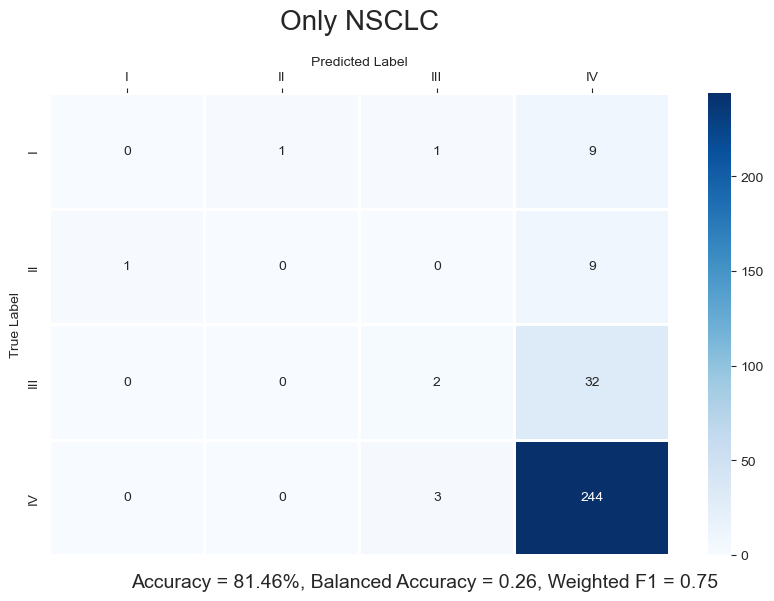

In [32]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

### Ovarian cancer

In [33]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    32
3    26
0    23
1    13
Name: Stage, dtype: int64

In [34]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-07 15:41:35,712] A new study created in memory with name: no-name-ba33eab3-625a-40e1-8085-6498e4214a74
[I 2023-06-07 15:41:47,274] Trial 0 finished with value: 0.33705357142857145 and parameters: {'n_estimators': 129, 'max_depth': 5, 'learning_rate': 0.2583532956355637, 'subsample': 0.7673960321248925, 'colsample_bytree': 0.8001008900940688, 'gamma': 3.1129170282943135}. Best is trial 0 with value: 0.33705357142857145.
[I 2023-06-07 15:41:57,482] Trial 1 finished with value: 0.35014880952380945 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.05784696183852334, 'subsample': 0.9533001750360868, 'colsample_bytree': 0.6378545475457642, 'gamma': 3.0209132752822034}. Best is trial 1 with value: 0.35014880952380945.
[I 2023-06-07 15:42:09,943] Trial 2 finished with value: 0.37418154761904765 and parameters: {'n_estimators': 106, 'max_depth': 5, 'learning_rate': 0.03584927270453339, 'subsample': 0.6458466450224318, 'colsample_bytree': 0.9163450108805644, 'ga

In [35]:
study.best_params

{'n_estimators': 108,
 'max_depth': 4,
 'learning_rate': 0.2518813211157735,
 'subsample': 0.6214832635417299,
 'colsample_bytree': 0.8371344304562022,
 'gamma': 2.255034851226871}

In [36]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [37]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.39      0.30      0.34        23
          II       0.33      0.08      0.12        13
         III       0.27      0.38      0.32        32
          IV       0.66      0.73      0.69        26

    accuracy                           0.41        94
   macro avg       0.41      0.37      0.37        94
weighted avg       0.42      0.41      0.40        94



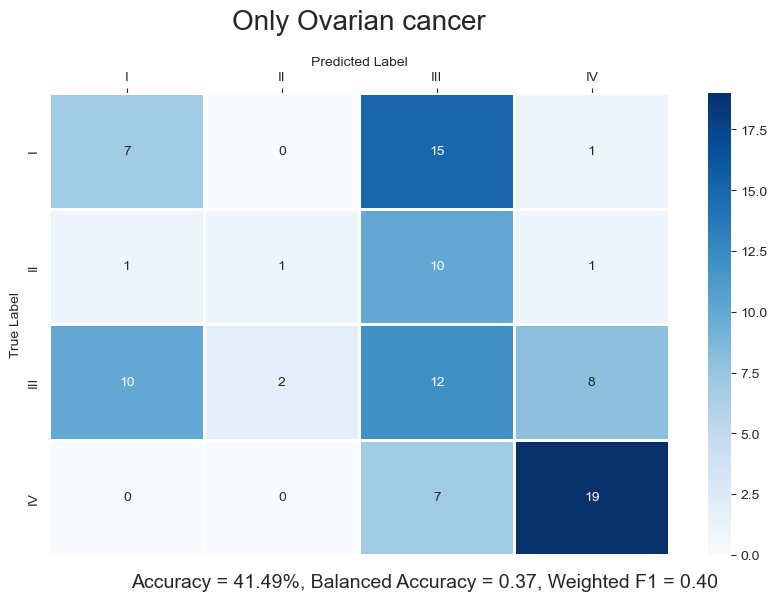

In [38]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

### Pancreatic cancer


In [39]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    48
2    23
3    18
0     2
Name: Stage, dtype: int64

In [40]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-07 15:59:38,284] A new study created in memory with name: no-name-00bf3ea7-ac1e-45d9-93a7-c1407ad45694
[I 2023-06-07 15:59:50,468] Trial 0 finished with value: 0.34687500000000004 and parameters: {'n_estimators': 128, 'max_depth': 2, 'learning_rate': 0.1908867938432816, 'subsample': 0.9728557100879284, 'colsample_bytree': 0.5056717039579066, 'gamma': 1.4599295953501552}. Best is trial 0 with value: 0.34687500000000004.
[I 2023-06-07 16:00:02,905] Trial 1 finished with value: 0.33923611111111107 and parameters: {'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.11383067736220968, 'subsample': 0.58832631707215, 'colsample_bytree': 0.576787359871287, 'gamma': 2.9587435620813607}. Best is trial 0 with value: 0.34687500000000004.
[I 2023-06-07 16:00:08,875] Trial 2 finished with value: 0.271875 and parameters: {'n_estimators': 41, 'max_depth': 8, 'learning_rate': 0.09887437903539226, 'subsample': 0.7802064617284539, 'colsample_bytree': 0.7612905666878358, 'gamma': 2.8235692

In [41]:
study.best_params

{'n_estimators': 57,
 'max_depth': 3,
 'learning_rate': 0.20585104311966737,
 'subsample': 0.6813634883341745,
 'colsample_bytree': 0.9920786029718839,
 'gamma': 4.897107211442154}

In [42]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [43]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.55      0.88      0.67        48
         III       0.20      0.04      0.07        23
          IV       0.44      0.22      0.30        18

    accuracy                           0.52        91
   macro avg       0.30      0.29      0.26        91
weighted avg       0.43      0.52      0.43        91



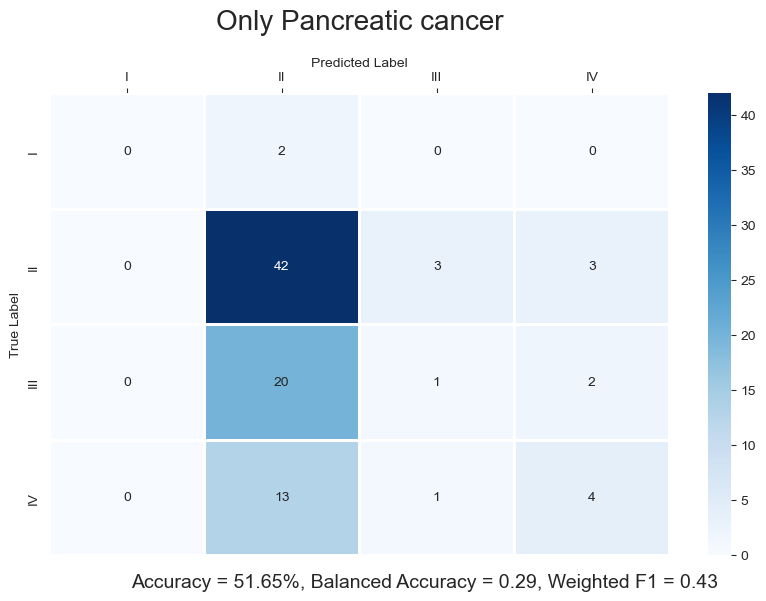

In [44]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Pancreatic cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [9]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

### NSCLC

In [46]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    247
0     55
Name: Stage, dtype: int64

In [47]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-07 16:16:18,183] A new study created in memory with name: no-name-f38b3c21-e82b-45a1-839f-42a828d19805
[I 2023-06-07 16:16:25,018] Trial 0 finished with value: 0.6007852164581408 and parameters: {'n_estimators': 56, 'max_depth': 5, 'learning_rate': 0.12994063214435667, 'subsample': 0.8580806509928994, 'colsample_bytree': 0.6040053514275627, 'gamma': 4.41900915475849}. Best is trial 0 with value: 0.6007852164581408.
[I 2023-06-07 16:16:31,633] Trial 1 finished with value: 0.630498379639046 and parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0.4666148173225621, 'subsample': 0.7918374330244646, 'colsample_bytree': 0.8833976115418879, 'gamma': 3.1705891425787147}. Best is trial 1 with value: 0.630498379639046.
[I 2023-06-07 16:16:39,166] Trial 2 finished with value: 0.6256133255075613 and parameters: {'n_estimators': 52, 'max_depth': 4, 'learning_rate': 0.019527022513224256, 'subsample': 0.7578018124958076, 'colsample_bytree': 0.6230126213662179, 'gamma': 3.610

In [48]:
study.best_params

{'n_estimators': 48,
 'max_depth': 4,
 'learning_rate': 0.3663933588936087,
 'subsample': 0.7339566156056458,
 'colsample_bytree': 0.5302615395445716,
 'gamma': 1.7343098156714911}

In [49]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [50]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.60      0.16      0.26        55
          IV       0.84      0.98      0.90       247

    accuracy                           0.83       302
   macro avg       0.72      0.57      0.58       302
weighted avg       0.80      0.83      0.79       302



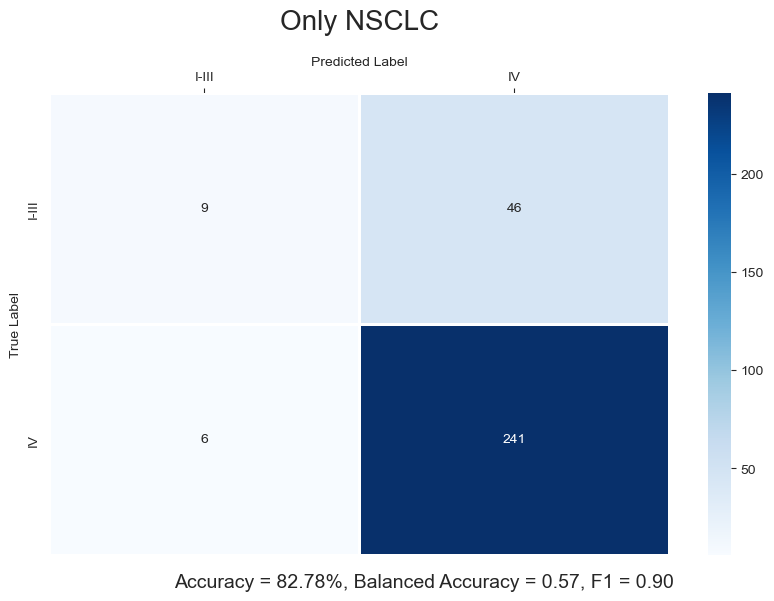

In [51]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

### Ovarian cancer

In [52]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    68
1    26
Name: Stage, dtype: int64

In [53]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-07 16:28:33,444] A new study created in memory with name: no-name-b46d2c65-ca57-4e9c-9d88-598ec470a084
[I 2023-06-07 16:28:42,373] Trial 0 finished with value: 0.6953270891690009 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.2036799688164083, 'subsample': 0.5884605365339495, 'colsample_bytree': 0.6658210321621183, 'gamma': 2.399083405447742}. Best is trial 0 with value: 0.6953270891690009.
[I 2023-06-07 16:28:50,104] Trial 1 finished with value: 0.7697318510737627 and parameters: {'n_estimators': 75, 'max_depth': 2, 'learning_rate': 0.300135259825909, 'subsample': 0.5817831216028336, 'colsample_bytree': 0.8684938943997963, 'gamma': 0.7880271515273707}. Best is trial 1 with value: 0.7697318510737627.
[I 2023-06-07 16:28:56,144] Trial 2 finished with value: 0.7592276493930905 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2377312306007937, 'subsample': 0.9885976779994445, 'colsample_bytree': 0.8700897096173209, 'gamma': 4.051

In [54]:
study.best_params

{'n_estimators': 26,
 'max_depth': 7,
 'learning_rate': 0.013980410605694032,
 'subsample': 0.9381917685509011,
 'colsample_bytree': 0.5074603229964296,
 'gamma': 4.975659269015074}

In [55]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [56]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.90      0.97      0.94        68
          IV       0.90      0.73      0.81        26

    accuracy                           0.90        94
   macro avg       0.90      0.85      0.87        94
weighted avg       0.90      0.90      0.90        94



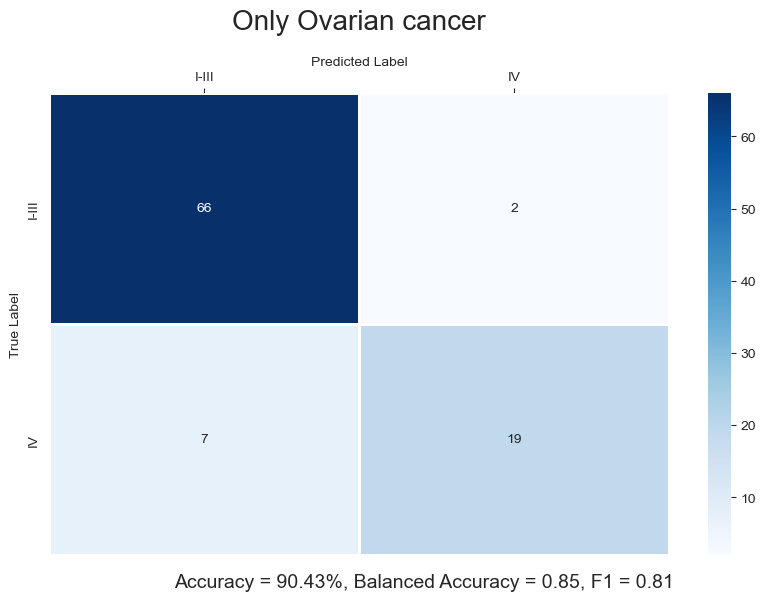

In [57]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)

### Pancreatic cancer

In [10]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    73
1    18
Name: Stage, dtype: int64

In [11]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-06-08 14:06:08,808] A new study created in memory with name: no-name-521283bd-104f-4165-9635-659b28b2bfac
[I 2023-06-08 14:06:16,784] Trial 0 finished with value: 0.5180555555555555 and parameters: {'n_estimators': 62, 'max_depth': 6, 'learning_rate': 0.2894552852822082, 'subsample': 0.9504314142296497, 'colsample_bytree': 0.8834131895989714, 'gamma': 0.5672802875573485}. Best is trial 0 with value: 0.5180555555555555.
[I 2023-06-08 14:06:23,053] Trial 1 finished with value: 0.5176470588235293 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.024806052951828386, 'subsample': 0.719352299105493, 'colsample_bytree': 0.5560996505326078, 'gamma': 3.1667997440003903}. Best is trial 0 with value: 0.5180555555555555.
[I 2023-06-08 14:06:29,867] Trial 2 finished with value: 0.5110681114551083 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.31092149483540865, 'subsample': 0.5620281612295319, 'colsample_bytree': 0.8903754874877707, 'gamma': 0.

In [12]:
study.best_params

{'n_estimators': 36,
 'max_depth': 4,
 'learning_rate': 0.32973153155230045,
 'subsample': 0.8446162993032931,
 'colsample_bytree': 0.9208853613628755,
 'gamma': 0.6363067588470305}

In [13]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [14]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.82      0.90      0.86        73
          IV       0.36      0.22      0.28        18

    accuracy                           0.77        91
   macro avg       0.59      0.56      0.57        91
weighted avg       0.73      0.77      0.75        91



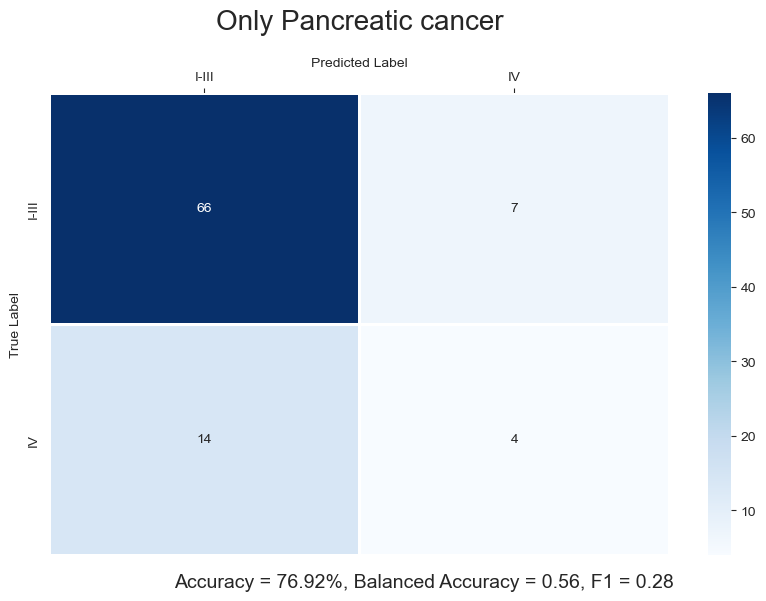

In [15]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Pancreatic cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title=title, scores_subtitle=scores_subtitle)